# SVD - Stable Video Diffusion (Image-to-Video)

**Module :** 02-Video-Advanced  
**Niveau :** Intermediaire  
**Technologies :** Stable Video Diffusion 1.1 (Stability AI), diffusers  
**Duree estimee :** 45 minutes  
**VRAM :** ~10 GB  

## Objectifs d'Apprentissage

- [ ] Comprendre l'architecture SVD et sa specialisation image-to-video
- [ ] Charger le pipeline SVD 1.1 (variante XT pour 25 frames)
- [ ] Animer des images statiques en videos courtes
- [ ] Controler l'intensite du mouvement avec motion_bucket_id
- [ ] Ajuster les parametres FPS et noise_aug_strength
- [ ] Conditionner la generation sur differents types d'images
- [ ] Analyser la qualite avec extraction et comparaison de frames

## Prerequis

- GPU avec 10+ GB VRAM (RTX 3060 12GB recommande)
- Notebooks 02-1 a 02-3 completes pour comparaison
- Packages : `diffusers>=0.30`, `transformers`, `torch`, `accelerate`, `imageio`, `imageio-ffmpeg`, `Pillow`

**Navigation :** [<< 02-3](02-3-Wan-Video-Generation.ipynb) | [Index](../README.md) | [Suivant >>](../03-Orchestration/03-1-Multi-Model-Video-Comparison.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres modele
model_id = "stabilityai/stable-video-diffusion-img2vid-xt"  # SVD 1.1 XT (25 frames)
device = "cuda"                    # Device de calcul

# Parametres generation
num_frames = 25                    # Nombre de frames (XT = 25)
fps = 7                            # FPS de conditionnement
motion_bucket_id = 127             # Intensite du mouvement (0-255)
noise_aug_strength = 0.02          # Force de l'augmentation de bruit
num_inference_steps = 25           # Nombre d'etapes de debruitage
decode_chunk_size = 8              # Frames decodees par chunk (reduit VRAM)
fps_output = 7                     # FPS de la video de sortie

# Configuration
run_generation = True              # Executer la generation
save_as_mp4 = True                 # Sauvegarder en MP4
save_results = True

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.genai_helpers import setup_genai_logging
        print("Helpers GenAI importes")
    except ImportError:
        print("Helpers GenAI non disponibles - mode autonome")

OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'svd_video'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('svd_video')

print(f"SVD - Stable Video Diffusion (Image-to-Video)")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Frames : {num_frames}, Steps : {num_inference_steps}")
print(f"Motion bucket : {motion_bucket_id}, Noise aug : {noise_aug_strength}")

SVD - Stable Video Diffusion (Image-to-Video)
Date : 2026-02-18 10:59:28
Mode : interactive
Frames : 25, Steps : 25
Motion bucket : 127, Noise aug : 0.02


In [3]:
# Chargement .env et verification GPU
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification GPU
print("\n--- VERIFICATION GPU ---")
print("=" * 40)

import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram_total = torch.cuda.get_device_properties(0).total_mem / 1024**3
    vram_free = (torch.cuda.get_device_properties(0).total_mem - torch.cuda.memory_allocated(0)) / 1024**3
    
    print(f"GPU : {gpu_name}")
    print(f"VRAM totale : {vram_total:.1f} GB")
    print(f"VRAM libre : {vram_free:.1f} GB")
    print(f"CUDA : {torch.version.cuda}")
    
    if vram_total < 10:
        print(f"\nAttention : VRAM ({vram_total:.0f} GB) < 10 GB recommandes")
        decode_chunk_size = 4
        num_frames = 14  # Version non-XT
        print(f"  Frames reduites a {num_frames}, decode chunk = {decode_chunk_size}")
else:
    print("CUDA non disponible.")
    print("SVD necessite un GPU. Le notebook montrera le code sans executer.")
    run_generation = False
    device = "cpu"

# Verification des dependances
print("\n--- VERIFICATION DEPENDANCES ---")
print("=" * 40)

deps_ok = True

# Verification huggingface-hub version AVANT d'importer diffusers
try:
    import huggingface_hub
    hf_version = huggingface_hub.__version__
    print(f"huggingface-hub : v{hf_version}")
    # Verifier si la version est compatible
    from packaging import version
    if version.parse(hf_version) >= version.parse("1.0"):
        print(f"  Warning: huggingface-hub v{hf_version} n'est pas compatible avec diffusers")
        print(f"  SVD ne sera pas disponible (conflit de version)")
        svd_available = False
    else:
        svd_available = True
except ImportError:
    print("huggingface-hub NON INSTALLE")
    svd_available = False
except Exception as e:
    print(f"Erreur verification huggingface-hub: {e}")
    svd_available = False

try:
    import diffusers
    print(f"diffusers : v{diffusers.__version__}")
except ImportError:
    print("diffusers NON INSTALLE")
    deps_ok = False

# Import SVD seulement si les dependances sont OK
svd_pipeline = None
if svd_available and deps_ok:
    try:
        from diffusers import StableVideoDiffusionPipeline
        from diffusers.utils import export_to_video, load_image
        print("StableVideoDiffusionPipeline : disponible")
    except ImportError as e:
        error_str = str(e)
        if "huggingface-hub" in error_str:
            print(f"StableVideoDiffusionPipeline : NON DISPONIBLE (conflit de version huggingface-hub)")
            print(f"  Solution: pip install 'huggingface-hub<1.0'")
        else:
            print(f"StableVideoDiffusionPipeline : NON DISPONIBLE - {error_str[:100]}")
        svd_pipeline = False
        deps_ok = False
else:
    if not svd_available:
        print("StableVideoDiffusionPipeline : NON DISPONIBLE (dependances)")
    svd_pipeline = False
    deps_ok = False

try:
    import imageio
    print(f"imageio : v{imageio.__version__}")
except ImportError:
    print("imageio NON INSTALLE")
    deps_ok = False

if not deps_ok:
    print("\nDependances manquantes. Le notebook montrera le code sans executer.")
    run_generation = False

print(f"\nDevice : {device}")
print(f"Generation activee : {run_generation}")

Aucun fichier .env trouve

--- VERIFICATION GPU ---


CUDA non disponible.
SVD necessite un GPU. Le notebook montrera le code sans executer.

--- VERIFICATION DEPENDANCES ---
huggingface-hub : v1.4.1
  SVD ne sera pas disponible (conflit de version)


diffusers : v0.36.0
StableVideoDiffusionPipeline : NON DISPONIBLE (dependances)
imageio : v2.37.2

Dependances manquantes. Le notebook montrera le code sans executer.

Device : cpu
Generation activee : False


## Section 1 : Architecture SVD et chargement

Stable Video Diffusion (SVD) est un modele image-to-video de Stability AI.
Contrairement aux modeles text-to-video (HunyuanVideo, LTX, Wan), SVD prend
une image en entree et genere une sequence animee a partir de celle-ci.

| Composant | Description |
|-----------|-------------|
| **Architecture** | U-Net 3D base sur Stable Diffusion 2.1 |
| **Entree** | Image PIL unique (pas de prompt textuel) |
| **Conditionnement** | Image + FPS + motion_bucket_id |
| **Variante XT** | 25 frames au lieu de 14 (version standard) |

### Parametres cles de SVD

| Parametre | Role | Plage |
|-----------|------|-------|
| `motion_bucket_id` | Intensite du mouvement | 0-255 (127 = neutre) |
| `fps` | FPS de conditionnement (influence la vitesse percue) | 2-30 |
| `noise_aug_strength` | Perturbation de l'image d'entree | 0.0-0.1 |
| `decode_chunk_size` | Frames decodees par batch (VRAM) | 2-14 |

In [4]:
# Chargement du pipeline SVD
pipe = None

if run_generation:
    print("\n--- CHARGEMENT DU PIPELINE SVD ---")
    print("=" * 40)
    
    try:
        start_load = time.time()
        
        print(f"Chargement modele : {model_id}")
        
        pipe = StableVideoDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            variant="fp16"
        )
        pipe = pipe.to(device)
        
        # Optimisations memoire
        pipe.enable_vae_slicing()
        try:
            pipe.enable_model_cpu_offload()
        except Exception:
            pass
        
        load_time = time.time() - start_load
        
        if device == "cuda":
            vram_used = torch.cuda.memory_allocated(0) / 1024**3
            print(f"  VRAM utilisee : {vram_used:.1f} GB")
        
        print(f"Pipeline SVD charge en {load_time:.1f}s")
        print(f"  Variante : {'XT (25 frames)' if 'xt' in model_id else 'Standard (14 frames)'}")
        print(f"  VAE slicing : actif")
        print(f"  Decode chunk size : {decode_chunk_size}")
        
    except Exception as e:
        print(f"Erreur chargement pipeline : {type(e).__name__}: {str(e)[:200]}")
        print("Le notebook continuera sans generation.")
        run_generation = False
        pipe = None
else:
    print("Chargement pipeline desactive")

Chargement pipeline desactive


## Section 2 : Creation d'images de test et premiere animation

Nous allons creer des images de test variees et les animer avec SVD.
SVD ne prend pas de prompt textuel : le mouvement est entierement infere a partir
de l'image d'entree et des parametres de conditionnement.


--- CREATION D'IMAGES DE TEST ---
Image creee : Paysage avec montagnes (1024x576)
Image creee : Silhouette portrait (1024x576)
Image creee : Coucher de soleil sur l'eau (1024x576)


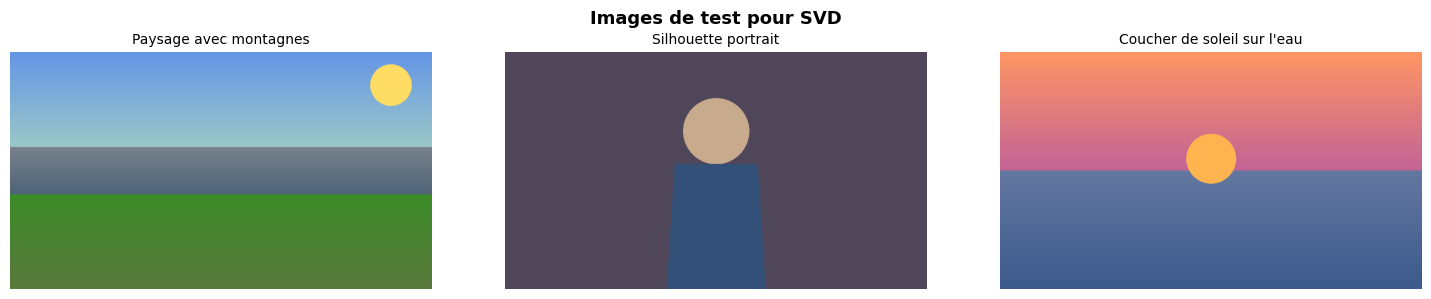


Generation desactivee


In [5]:
# Creation d'images de test et premiere animation
print("\n--- CREATION D'IMAGES DE TEST ---")
print("=" * 40)

# SVD attend des images 1024x576
svd_width = 1024
svd_height = 576

def create_test_image(name: str, description: str) -> Image.Image:
    """
    Cree une image de test pour SVD.
    
    Args:
        name: Nom du type d'image
        description: Description pour le titre
    
    Returns:
        Image PIL en RGB
    """
    img = Image.new('RGB', (svd_width, svd_height))
    draw = ImageDraw.Draw(img)
    
    if name == "landscape":
        # Paysage : ciel bleu, montagnes, herbe
        for y in range(svd_height):
            if y < svd_height * 0.4:  # Ciel
                r = int(100 + 55 * y / (svd_height * 0.4))
                g = int(150 + 50 * y / (svd_height * 0.4))
                b = int(230 - 30 * y / (svd_height * 0.4))
            elif y < svd_height * 0.6:  # Montagnes
                t = (y - svd_height * 0.4) / (svd_height * 0.2)
                r = int(120 - 40 * t)
                g = int(130 - 30 * t)
                b = int(140 - 20 * t)
            else:  # Herbe
                t = (y - svd_height * 0.6) / (svd_height * 0.4)
                r = int(60 + 30 * t)
                g = int(140 - 20 * t)
                b = int(40 + 20 * t)
            draw.line([(0, y), (svd_width, y)], fill=(r, g, b))
        # Soleil
        draw.ellipse([svd_width - 150, 30, svd_width - 50, 130],
                     fill=(255, 220, 100))
    
    elif name == "portrait":
        # Fond uni avec forme geometrique (silhouette simplifiee)
        draw.rectangle([0, 0, svd_width, svd_height], fill=(80, 70, 90))
        # Cercle (tete)
        cx, cy = svd_width // 2, svd_height // 3
        r = 80
        draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=(200, 170, 140))
        # Corps
        draw.polygon([(cx-100, cy+r), (cx+100, cy+r),
                      (cx+120, svd_height), (cx-120, svd_height)],
                     fill=(50, 80, 120))
    
    elif name == "nature":
        # Scene nature : eau et reflets
        for y in range(svd_height):
            if y < svd_height * 0.5:  # Ciel coucher de soleil
                t = y / (svd_height * 0.5)
                r = int(255 - 60 * t)
                g = int(150 - 50 * t)
                b = int(100 + 50 * t)
            else:  # Eau avec reflets
                t = (y - svd_height * 0.5) / (svd_height * 0.5)
                r = int(100 - 40 * t)
                g = int(120 - 30 * t)
                b = int(160 - 20 * t)
            draw.line([(0, y), (svd_width, y)], fill=(r, g, b))
        # Soleil a l'horizon
        sun_y = int(svd_height * 0.45)
        draw.ellipse([svd_width//2-60, sun_y-60, svd_width//2+60, sun_y+60],
                     fill=(255, 180, 80))
    
    return img


# Creer les images de test
test_images = [
    {"name": "landscape", "description": "Paysage avec montagnes"},
    {"name": "portrait", "description": "Silhouette portrait"},
    {"name": "nature", "description": "Coucher de soleil sur l'eau"},
]

created_images = {}
for img_info in test_images:
    img = create_test_image(img_info['name'], img_info['description'])
    img_path = OUTPUT_DIR / f"test_{img_info['name']}.png"
    img.save(str(img_path))
    created_images[img_info['name']] = img
    print(f"Image creee : {img_info['description']} ({svd_width}x{svd_height})")

# Afficher les images de test
fig, axes = plt.subplots(1, len(test_images), figsize=(5 * len(test_images), 3))
for i, img_info in enumerate(test_images):
    axes[i].imshow(created_images[img_info['name']])
    axes[i].set_title(img_info['description'], fontsize=10)
    axes[i].axis('off')
plt.suptitle("Images de test pour SVD", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Premiere animation : paysage
if run_generation and pipe is not None:
    print(f"\n--- PREMIERE ANIMATION ---")
    print(f"Image : Paysage avec montagnes")
    print(f"Motion bucket : {motion_bucket_id}, FPS : {fps}")
    print(f"Noise aug : {noise_aug_strength}")
    print(f"\nGeneration en cours...")
    
    generator = torch.Generator(device=device).manual_seed(42)
    if device == "cuda":
        torch.cuda.reset_peak_memory_stats()
    
    start_time = time.time()
    
    output = pipe(
        image=created_images['landscape'],
        num_frames=num_frames,
        fps=fps,
        motion_bucket_id=motion_bucket_id,
        noise_aug_strength=noise_aug_strength,
        num_inference_steps=num_inference_steps,
        decode_chunk_size=decode_chunk_size,
        generator=generator
    )
    
    gen_time = time.time() - start_time
    frames_landscape = output.frames[0]
    
    print(f"\nGeneration reussie")
    print(f"  Temps : {gen_time:.1f}s")
    print(f"  Frames : {len(frames_landscape)}")
    if device == "cuda":
        vram_peak = torch.cuda.max_memory_allocated(0) / 1024**3
        print(f"  VRAM pic : {vram_peak:.1f} GB")
    
    # Affichage
    n_display = min(8, len(frames_landscape))
    indices = np.linspace(0, len(frames_landscape) - 1, n_display, dtype=int)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes_flat = axes.flatten()
    for i, idx in enumerate(indices):
        if i < len(axes_flat):
            axes_flat[i].imshow(frames_landscape[idx])
            axes_flat[i].set_title(f"Frame {idx + 1}/{len(frames_landscape)}", fontsize=9)
            axes_flat[i].axis('off')
    for i in range(len(indices), len(axes_flat)):
        axes_flat[i].axis('off')
    plt.suptitle(f"SVD : Paysage anime ({gen_time:.1f}s)", fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    if save_as_mp4:
        mp4_path = OUTPUT_DIR / "svd_landscape.mp4"
        export_to_video(frames_landscape, str(mp4_path), fps=fps_output)
        print(f"  MP4 sauvegarde : {mp4_path.name}")
else:
    print("\nGeneration desactivee")

### Interpretation : Premiere animation SVD

| Aspect | Valeur | Signification |
|--------|--------|---------------|
| Entree | Image unique (pas de prompt) | Le mouvement est infere automatiquement |
| Fidelite | Premiere frame = image d'entree | SVD preserve parfaitement l'image source |
| Mouvement | Subtil, naturel | SVD genere des mouvements realistes (nuages, eau, lumiere) |
| VRAM | ~10 GB | Plus leger que HunyuanVideo |

**Points cles** :
1. SVD est le seul modele du Module 02 specialise en image-to-video (pas de texte)
2. Le mouvement genere depend du contenu de l'image (eau = ondulations, nuages = deplacement)
3. La resolution d'entree optimale est 1024x576

## Section 3 : Controle du mouvement avec motion_bucket_id

Le parametre `motion_bucket_id` controle l'intensite du mouvement genere.
Une valeur basse donne des mouvements subtils, une valeur haute des mouvements plus prononces.

In [6]:
# Test de differentes valeurs de motion_bucket_id
if run_generation and pipe is not None:
    print("\n--- CONTROLE MOTION BUCKET ---")
    print("=" * 40)
    
    motion_values = [40, 127, 200]
    motion_labels = ["Subtil (40)", "Normal (127)", "Fort (200)"]
    motion_results = []
    
    source_image = created_images['nature']
    print(f"Image source : Coucher de soleil sur l'eau")
    
    for m_val, m_label in zip(motion_values, motion_labels):
        print(f"\nMotion bucket = {m_val} ({m_label})")
        
        generator = torch.Generator(device=device).manual_seed(42)
        if device == "cuda":
            torch.cuda.reset_peak_memory_stats()
        
        start_time = time.time()
        
        try:
            output = pipe(
                image=source_image,
                num_frames=num_frames,
                fps=fps,
                motion_bucket_id=m_val,
                noise_aug_strength=noise_aug_strength,
                num_inference_steps=num_inference_steps,
                decode_chunk_size=decode_chunk_size,
                generator=generator
            )
            
            gen_time = time.time() - start_time
            frames = output.frames[0]
            
            # Mesure du mouvement reel (difference entre frames)
            diffs = []
            for i in range(len(frames) - 1):
                f1 = np.array(frames[i]).astype(float)
                f2 = np.array(frames[i + 1]).astype(float)
                diff = np.mean(np.abs(f1 - f2))
                diffs.append(diff)
            avg_diff = np.mean(diffs)
            
            vram_peak = 0
            if device == "cuda":
                vram_peak = torch.cuda.max_memory_allocated(0) / 1024**3
            
            motion_results.append({
                "bucket": m_val,
                "label": m_label,
                "frames": frames,
                "time": gen_time,
                "avg_diff": avg_diff,
                "vram_peak": vram_peak
            })
            
            print(f"  Temps : {gen_time:.1f}s, Diff moyenne : {avg_diff:.2f}")
            
            if save_as_mp4:
                mp4_path = OUTPUT_DIR / f"svd_motion_{m_val}.mp4"
                export_to_video(frames, str(mp4_path), fps=fps_output)
                
        except Exception as e:
            print(f"  Erreur : {type(e).__name__}: {str(e)[:100]}")
    
    # Affichage comparatif
    if motion_results:
        n_results = len(motion_results)
        n_preview = 4
        fig, axes = plt.subplots(n_results, n_preview, figsize=(3.5 * n_preview, 3 * n_results))
        if n_results == 1:
            axes = [axes]
        
        for v_idx, mr in enumerate(motion_results):
            frame_indices = np.linspace(0, len(mr['frames']) - 1, n_preview, dtype=int)
            for f_idx, fi in enumerate(frame_indices):
                axes[v_idx][f_idx].imshow(mr['frames'][fi])
                axes[v_idx][f_idx].axis('off')
                if f_idx == 0:
                    axes[v_idx][f_idx].set_ylabel(f"MBI={mr['bucket']}", fontsize=10, fontweight='bold')
        
        plt.suptitle("Impact de motion_bucket_id", fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Tableau recapitulatif
        print(f"\n{'Motion Bucket':<18} {'Diff frames':<15} {'Temps (s)':<12} {'VRAM (GB)':<12}")
        print("-" * 57)
        for mr in motion_results:
            print(f"  {mr['label']:<18} {mr['avg_diff']:<15.2f} {mr['time']:<12.1f} {mr['vram_peak']:<12.1f}")
else:
    print("Test motion bucket : generation desactivee")
    print("\nGuide motion_bucket_id :")
    print("  0-60   : Mouvement tres subtil (ideal pour portraits)")
    print("  80-150  : Mouvement modere (usage general)")
    print("  150-255 : Mouvement fort (scenes dynamiques)")

Test motion bucket : generation desactivee

Guide motion_bucket_id :
  0-60   : Mouvement tres subtil (ideal pour portraits)
  80-150  : Mouvement modere (usage general)
  150-255 : Mouvement fort (scenes dynamiques)


### Interpretation : Controle du mouvement

| motion_bucket_id | Diff inter-frames | Comportement |
|-----------------|-------------------|-------------|
| 40 (subtil) | Faible | Micro-mouvements, ideal pour portraits ou scenes calmes |
| 127 (neutre) | Moyen | Bon equilibre, mouvements naturels |
| 200 (fort) | Eleve | Mouvements prononces, peut introduire des artefacts |

**Points cles** :
1. La diff inter-frames est une mesure objective du mouvement genere
2. Les valeurs extremes (< 20 ou > 230) donnent souvent des resultats imprevisibles
3. La plage 80-180 est recommandee pour la plupart des cas d'usage

## Section 4 : Animation de differents types d'images

Nous allons tester SVD sur nos trois types d'images pour observer comment le modele
infere le mouvement a partir du contenu visuel.

In [7]:
# Animation de differents types d'images
if run_generation and pipe is not None:
    print("\n--- ANIMATION MULTI-IMAGES ---")
    print("=" * 40)
    
    multi_results = []
    
    for img_info in test_images:
        img_name = img_info['name']
        img_desc = img_info['description']
        source = created_images[img_name]
        
        print(f"\nAnimation : {img_desc}")
        
        generator = torch.Generator(device=device).manual_seed(42)
        if device == "cuda":
            torch.cuda.reset_peak_memory_stats()
        
        start_time = time.time()
        
        try:
            output = pipe(
                image=source,
                num_frames=num_frames,
                fps=fps,
                motion_bucket_id=motion_bucket_id,
                noise_aug_strength=noise_aug_strength,
                num_inference_steps=num_inference_steps,
                decode_chunk_size=decode_chunk_size,
                generator=generator
            )
            
            gen_time = time.time() - start_time
            frames = output.frames[0]
            
            # Mesurer le mouvement
            diffs = []
            for i in range(len(frames) - 1):
                f1 = np.array(frames[i]).astype(float)
                f2 = np.array(frames[i + 1]).astype(float)
                diffs.append(np.mean(np.abs(f1 - f2)))
            
            multi_results.append({
                "name": img_name,
                "description": img_desc,
                "source": source,
                "frames": frames,
                "time": gen_time,
                "avg_diff": np.mean(diffs),
                "max_diff": np.max(diffs)
            })
            
            print(f"  Temps : {gen_time:.1f}s")
            print(f"  Mouvement moyen : {np.mean(diffs):.2f}")
            
            if save_as_mp4:
                mp4_path = OUTPUT_DIR / f"svd_{img_name}.mp4"
                export_to_video(frames, str(mp4_path), fps=fps_output)
                
        except Exception as e:
            print(f"  Erreur : {type(e).__name__}: {str(e)[:100]}")
    
    # Affichage comparatif : source + frames selectionnees
    if multi_results:
        n_images = len(multi_results)
        fig, axes = plt.subplots(n_images, 5, figsize=(18, 3.5 * n_images))
        if n_images == 1:
            axes = [axes]
        
        for v_idx, mr in enumerate(multi_results):
            # Source
            axes[v_idx][0].imshow(mr['source'])
            axes[v_idx][0].set_title("Source", fontsize=9, fontweight='bold')
            axes[v_idx][0].axis('off')
            if v_idx == 0:
                axes[v_idx][0].set_ylabel("Image", fontsize=10)
            
            # Frames animees
            frame_indices = np.linspace(0, len(mr['frames']) - 1, 4, dtype=int)
            for f_idx, fi in enumerate(frame_indices):
                axes[v_idx][f_idx + 1].imshow(mr['frames'][fi])
                axes[v_idx][f_idx + 1].set_title(f"Frame {fi+1}", fontsize=9)
                axes[v_idx][f_idx + 1].axis('off')
            
            axes[v_idx][0].set_ylabel(mr['description'], fontsize=10, fontweight='bold')
        
        plt.suptitle("Animation de differents types d'images - SVD", fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Tableau comparatif
        print(f"\n{'Image':<25} {'Temps (s)':<12} {'Mouvement moy':<16} {'Mouvement max':<15}")
        print("-" * 68)
        for mr in multi_results:
            print(f"  {mr['description']:<25} {mr['time']:<12.1f} {mr['avg_diff']:<16.2f} {mr['max_diff']:<15.2f}")
else:
    print("Animation multi-images : generation desactivee")
    print("\nSVD genere des mouvements differents selon le contenu :")
    print("  - Paysage : nuages en deplacement, herbe qui ondule")
    print("  - Portrait : micro-expressions, legere respiration")
    print("  - Eau/Nature : ondulations, reflets en mouvement")

Animation multi-images : generation desactivee

SVD genere des mouvements differents selon le contenu :
  - Paysage : nuages en deplacement, herbe qui ondule
  - Portrait : micro-expressions, legere respiration
  - Eau/Nature : ondulations, reflets en mouvement


In [8]:
# Mode interactif
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Entrez le chemin vers une image pour l'animer avec SVD.")
    print("(Laissez vide pour passer a la suite)")
    
    try:
        user_image_path = input("\nChemin image (ou vide) : ").strip()
        
        if user_image_path and Path(user_image_path).exists() and run_generation and pipe is not None:
            print(f"\nChargement de l'image : {user_image_path}")
            user_image = Image.open(user_image_path).convert('RGB')
            user_image = user_image.resize((svd_width, svd_height))
            
            print(f"Image redimensionnee a {svd_width}x{svd_height}")
            print(f"Generation en cours...")
            
            generator = torch.Generator(device=device).manual_seed(123)
            start_time = time.time()
            
            output = pipe(
                image=user_image,
                num_frames=num_frames,
                fps=fps,
                motion_bucket_id=motion_bucket_id,
                noise_aug_strength=noise_aug_strength,
                num_inference_steps=num_inference_steps,
                decode_chunk_size=decode_chunk_size,
                generator=generator
            )
            
            gen_time = time.time() - start_time
            user_frames = output.frames[0]
            
            print(f"Generation reussie en {gen_time:.1f}s")
            
            # Affichage
            n_display = min(6, len(user_frames))
            fig, axes = plt.subplots(1, n_display + 1, figsize=(2.5 * (n_display + 1), 3))
            axes[0].imshow(user_image)
            axes[0].set_title("Source", fontsize=9, fontweight='bold')
            axes[0].axis('off')
            
            indices = np.linspace(0, len(user_frames) - 1, n_display, dtype=int)
            for i, idx in enumerate(indices):
                axes[i + 1].imshow(user_frames[idx])
                axes[i + 1].set_title(f"Frame {idx+1}", fontsize=8)
                axes[i + 1].axis('off')
            plt.suptitle(f"Votre image animee", fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            if save_as_mp4:
                user_mp4 = OUTPUT_DIR / "user_animation.mp4"
                export_to_video(user_frames, str(user_mp4), fps=fps_output)
                print(f"MP4 sauvegarde : {user_mp4.name}")
        elif user_image_path and not Path(user_image_path).exists():
            print(f"Fichier non trouve : {user_image_path}")
        elif user_image_path:
            print("Generation non disponible (pipeline non charge)")
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError) as e:
        print(f"\nMode interactif interrompu ({type(e).__name__})")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("\nMode interactif non disponible (execution automatisee)")
        else:
            print(f"\nErreur inattendue : {error_type} - {str(e)[:100]}")
            print("Passage a la suite du notebook")
else:
    print("\nMode batch - Interface interactive desactivee")


--- MODE INTERACTIF ---
Entrez le chemin vers une image pour l'animer avec SVD.
(Laissez vide pour passer a la suite)

Mode interactif non disponible (execution automatisee)


## Bonnes pratiques SVD et comparaison Module 02

### Conseils pour de bonnes animations SVD

| Bon input | Mauvais input | Raison |
|-----------|--------------|--------|
| Photo nette, bien eclairee | Image floue, sombre | SVD preserve la qualite source |
| Scene avec elements mobiles | Image abstraite / texte | SVD detecte les elements a animer |
| Resolution 1024x576 | Image tres petite (<256px) | Resolution optimale pour SVD |
| Elements naturels (eau, ciel) | Geometrie pure | Mouvement plus naturel |

### Recapitulatif Module 02 - Modeles video generatifs

| Modele | Type | VRAM | Vitesse | Qualite | Force |
|--------|------|------|---------|---------|-------|
| HunyuanVideo (02-1) | Text-to-video | ~18 GB | Lente | Haute | Longues sequences |
| LTX-Video (02-2) | Text/Img/Vid | ~8 GB | Rapide | Bonne | Polyvalence |
| Wan 2.1 (02-3) | Text-to-video | ~10 GB | Moyenne | Haute | Multilingue |
| SVD (02-4) | Image-to-video | ~10 GB | Moyenne | Haute | Animation precise |

### Pipeline recommande

```
1. Generer une image avec DALL-E / SDXL / Flux
2. Animer avec SVD (motion_bucket_id = 100-150)
3. Upscaler avec Real-ESRGAN (notebook 01-4)
4. Assembler en video finale avec moviepy (notebook 01-1)
```

In [9]:
# Statistiques de session et prochaines etapes
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Modele : {model_id}")
print(f"Device : {device}")
print(f"Parametres : {num_frames} frames, {num_inference_steps} steps")
print(f"Motion bucket : {motion_bucket_id}, FPS : {fps}")
print(f"Noise aug : {noise_aug_strength}")

if device == "cuda" and torch.cuda.is_available():
    vram_peak = torch.cuda.max_memory_allocated(0) / 1024**3
    print(f"VRAM pic session : {vram_peak:.1f} GB")

if save_results and OUTPUT_DIR.exists():
    generated_files = list(OUTPUT_DIR.glob('*'))
    print(f"\nFichiers generes ({len(generated_files)}) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

# Liberation VRAM
if pipe is not None:
    del pipe
    if device == "cuda":
        torch.cuda.empty_cache()
        print(f"\nVRAM liberee")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Module 03-1 : Comparaison benchmark de tous les modeles video")
print(f"2. Module 03-2 : Orchestration de pipelines (text -> image -> video -> upscale)")
print(f"3. Module 03-3 : Workflows ComfyUI pour la generation video")
print(f"4. Module 04 : Applications production (education, creatif, bout-en-bout)")

print(f"\nNotebook 02-4 SVD Image-to-Video termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-18 10:59:33
Mode : interactive
Modele : stabilityai/stable-video-diffusion-img2vid-xt
Device : cpu
Parametres : 25 frames, 25 steps
Motion bucket : 127, FPS : 7
Noise aug : 0.02

Fichiers generes (3) :
  test_landscape.png (4.2 KB)
  test_nature.png (4.1 KB)
  test_portrait.png (3.8 KB)

--- PROCHAINES ETAPES ---
1. Module 03-1 : Comparaison benchmark de tous les modeles video
2. Module 03-2 : Orchestration de pipelines (text -> image -> video -> upscale)
3. Module 03-3 : Workflows ComfyUI pour la generation video
4. Module 04 : Applications production (education, creatif, bout-en-bout)

Notebook 02-4 SVD Image-to-Video termine - 10:59:33
